# 1. Describe the data
- It has 54 rows.
- There are 3 variables:
    - breaks: This variable represents the number of breaks in the yarn. It’s a numeric variable indicating how many times the yarn broke during the weaving process.
    - wool: This is a categorical variable with two levels: “A” and “B”. It indicates the type of wool used.
    - tension: This is another categorical variable with three levels: “L”, “M”, and “H”. It represents the tension level applied during the weaving process, where “L” stands for low, “M” for medium, and “H” for high.
- An industrial experiment examined warp breaks in yarn based on two wool types and three tension levels in a weaving machine. Data is in Tukey (1977).

# 2. Load packages and data

In [1]:
%%capture
pip install faraway

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from scipy import stats
import faraway.utils

In [3]:
import faraway.datasets.warpbreaks
warpbreaks = faraway.datasets.warpbreaks.load()
warpbreaks.head()

,breaks,wool,tension
1,26,A,L
2,30,A,L
3,54,A,L
4,25,A,L
5,70,A,L


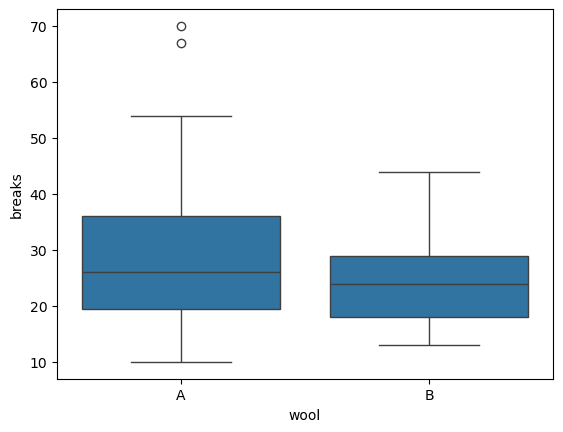

In [5]:
sns.boxplot(x="wool", y="breaks", data=warpbreaks);

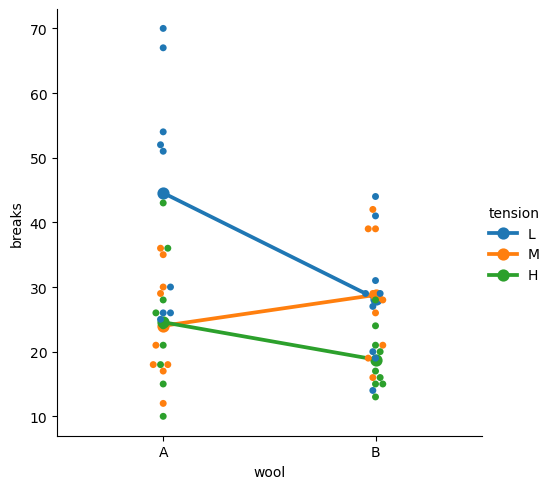

In [6]:
# Create a point plot using seaborn's catplot function
# - hue: group by 'tension' levels
# - errorbar: set to None to disable error bars
# - kind: specify the type of plot, which is 'point'
ax = sns.catplot(x='wool', y='breaks', hue='tension', 
    data=warpbreaks, errorbar=None, kind="point")

# Overlay a swarm plot on the same axes using seaborn's swarmplot function
# - hue: group by 'tension' levels
# - data: dataset 'warpbreaks'
ax = sns.swarmplot(x='wool', y='breaks', hue='tension', 
    data=warpbreaks)
ax.legend_.remove()

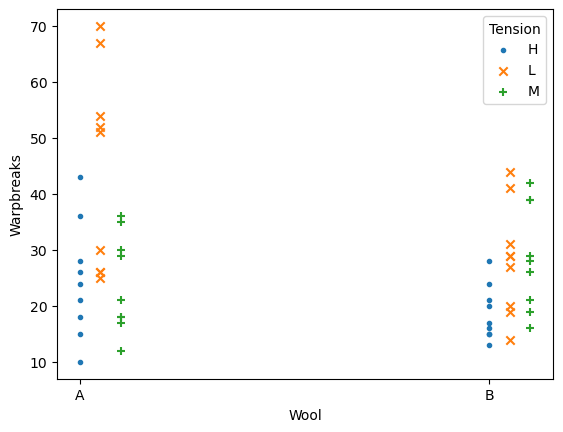

In [8]:
# Create a new column 'nwool' in the dataframe 'warpbreaks'
# Assign 0 if the 'wool' column value is 'A', otherwise assign 1
warpbreaks['nwool'] = np.where(warpbreaks['wool'] == 'A', 0, 1)

# Get unique levels of the 'tension' column in the dataframe 'warpbreaks'
faclevels = np.unique(warpbreaks.tension)

# Define a list of markers to use for plotting different tension levels
markseq = [".", "x", "+"]

# Loop over each unique tension level
for i in np.arange(len(faclevels)):
    # Create a boolean mask for rows where 'tension' equals the current level
    j = (warpbreaks.tension == faclevels[i])
    
    # Plot a scatter plot for the current tension level
    # - x-axis: 'nwool' values adjusted by 0.05 * current index
    # - y-axis: 'breaks' values
    # - marker: marker type from 'markseq' corresponding to the current index
    # - label: current tension level
    plt.scatter(warpbreaks.nwool[j] + 0.05 * i, warpbreaks.breaks[j],
                marker=markseq[i], label=faclevels[i])
plt.legend(title="Tension"); plt.xlabel("Wool"); plt.xticks([0, 1], ["A", "B"]); plt.ylabel("Warpbreaks");

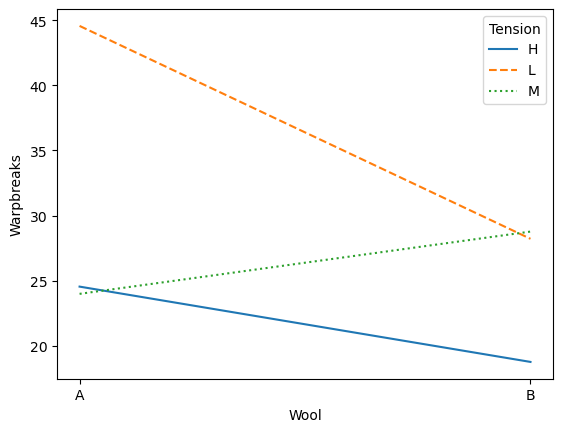

In [9]:
# Group the 'warpbreaks' dataframe by 'wool' and 'tension' columns,
# then calculate the mean of the 'breaks' column for each group
# Finally, reset the index to turn the grouped object back into a dataframe
wm = warpbreaks.groupby(
    ['wool', 'tension'])[['breaks']].mean().reset_index()

# Get unique levels of the 'tension' column in the 'wm' dataframe
faclevels = np.unique(wm.tension)

# Define a list of line styles to use for plotting different tension levels
lineseq = ['-', '--', ':']

# Loop over each unique tension level
for i in np.arange(len(faclevels)):
    # Create a boolean mask for rows where 'tension' equals the current level
    j = (wm.tension == faclevels[i])
    
    # Plot a line plot for the current tension level
    # - x-axis: 'wool' values filtered by the mask
    # - y-axis: 'breaks' values filtered by the mask
    # - style: line style from 'lineseq' corresponding to the current index
    # - label: current tension level
    plt.plot(wm.wool[j], wm.breaks[j], lineseq[i],
             label=faclevels[i])
plt.legend(title="Tension"); plt.xlabel("Wool"); plt.ylabel("Warpbreaks");

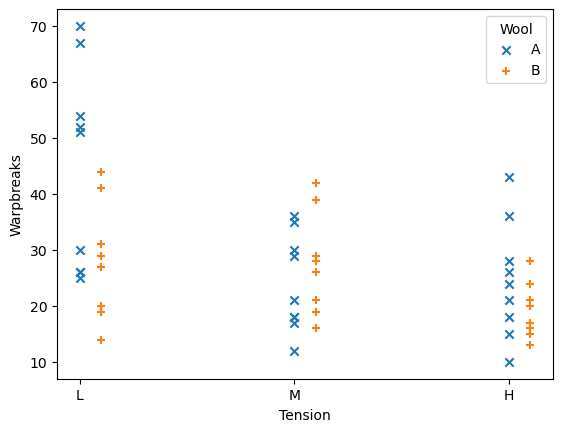

In [10]:
# Create a new column 'ntension' in the dataframe 'warpbreaks'
# Assign 0 if the 'tension' column value is 'L', 1 if it's 'M', and 2 if it's 'H'
warpbreaks['ntension'] = \
    np.where(warpbreaks['tension'] == 'L', 
    0, np.where(warpbreaks['tension'] == 'M', 1, 2))

# Get unique levels of the 'wool' column in the dataframe 'warpbreaks'
faclevels = np.unique(warpbreaks.wool)

# Define a list of markers to use for plotting different wool levels
markseq = ["x", "+"]

# Loop over each unique wool level
for i in np.arange(len(faclevels)):
    # Create a boolean mask for rows where 'wool' equals the current level
    j = (warpbreaks.wool == faclevels[i])
    
    # Plot a scatter plot for the current wool level
    # - x-axis: 'ntension' values adjusted by 0.1 * current index
    # - y-axis: 'breaks' values
    # - marker: marker type from 'markseq' corresponding to the current index
    # - label: current wool level
    plt.scatter(warpbreaks.ntension[j] + 0.1 * i, 
                warpbreaks.breaks[j],
                marker=markseq[i],
                label=faclevels[i])
plt.legend(title="Wool"); plt.xlabel("Tension")
plt.xticks([0,1,2],["L","M","H"]); plt.ylabel("Warpbreaks");

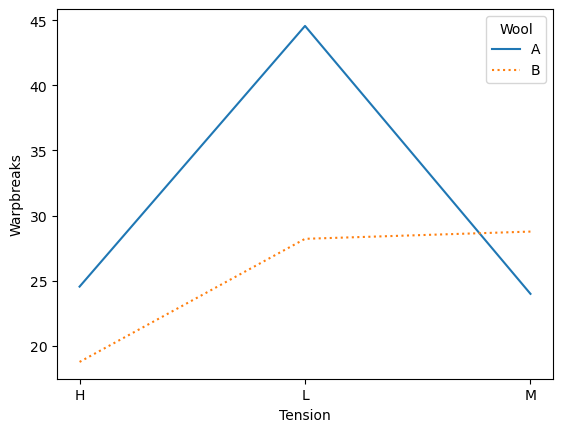

In [11]:
# Define a list of line styles to use for plotting different wool levels
lineseq = ["-", ":"]

# Loop over each unique wool level
for i in np.arange(len(faclevels)):
    # Create a boolean mask for rows where 'wool' equals the current level
    j = (wm.wool == faclevels[i])
    
    # Plot a line plot for the current wool level
    # - x-axis: 'tension' values filtered by the mask
    # - y-axis: 'breaks' values filtered by the mask
    # - style: line style from 'lineseq' corresponding to the current index
    # - label: current wool level
    plt.plot(wm.tension[j], wm.breaks[j],
             lineseq[i], label=faclevels[i])
plt.legend(title="Wool"); plt.xlabel("Tension"); plt.ylabel("Warpbreaks");

- There is evidence of non-constant variation and potential interaction between factors, as the lines joining the mean responses at each level are not parallel.

# 3. Two Factors with an Interaction

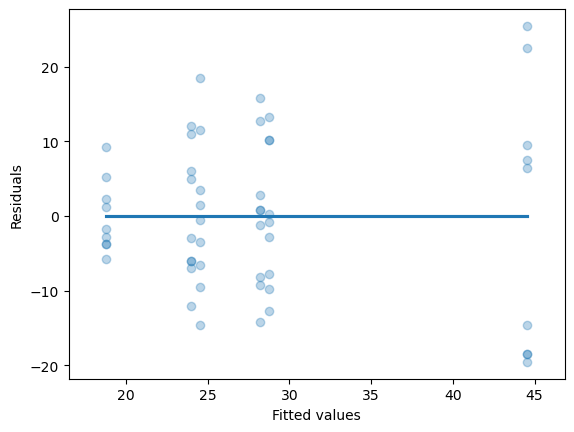

In [14]:
# Fit an Ordinary Least Squares (OLS) regression model using the formula
# 'breaks ~ wool * tension' on the 'warpbreaks' dataframe
# This models the 'breaks' variable as a function of 'wool', 'tension', and their interaction
lmod = smf.ols('breaks ~ wool * tension', warpbreaks).fit()

# Create a new figure and axes for plotting
fig, ax = plt.subplots()

# Create a regression plot using seaborn's regplot function
# - x: fitted values from the OLS model
# - y: residuals from the OLS model
# - scatter_kws: specify transparency of the scatter points (alpha=0.3)
# - ci: set to None to omit the confidence interval
# - ax: specify the axes to plot on
sns.regplot(x=lmod.fittedvalues, y=lmod.resid,
    scatter_kws={'alpha': 0.3}, ci=None, ax=ax)
ax.set_xlim(np.array(ax.get_xlim())+[-1,1]); ax.set_xlabel("Fitted values"); ax.set_ylabel("Residuals");

- The residuals vs. fitted plot shows increasing variation with the response. Since the response is a count variable, a square root transformation is recommended:

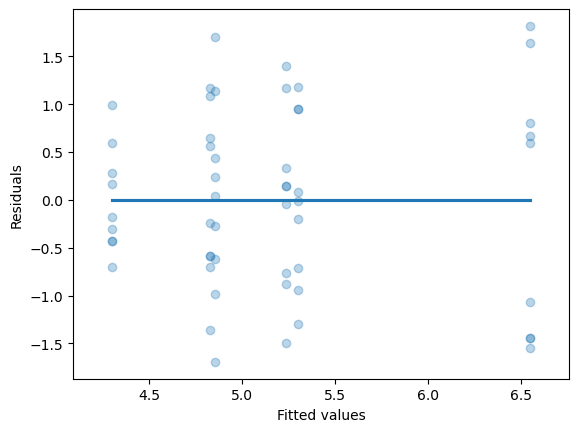

In [15]:
lmod = smf.ols('np.sqrt(breaks) ~ wool * tension', 
    warpbreaks).fit()
fig, ax = plt.subplots()
sns.regplot(x=lmod.fittedvalues,y=lmod.resid,
    scatter_kws={'alpha':0.3}, ci=None, ax=ax)
ax.set_xlim(np.array(ax.get_xlim())+[-0.1,0.1]); ax.set_xlabel("Fitted values"); ax.set_ylabel("Residuals");

- The diagnostic plot shows an improvement.
- We can now test for the significance of the effects:

In [16]:
sm.stats.anova_lm(lmod).round(4)

,df,sum_sq,mean_sq,F,PR(>F)
wool,1.0,2.9019,2.9019,3.0222,0.0885
tension,2.0,15.8916,7.9458,8.2752,0.0008
wool:tension,2.0,7.2014,3.6007,3.7500,0.0307
Residual,48.0,46.0892,0.9602,NaN,NaN


- There is a significant interaction effect between the factors, meaning the effect of wool cannot be considered independently of tension. The main effect for wool is not significant, but this does not imply wool has no effect. Consider the regression output for clarity:

In [17]:
lmod.sumary()

                        coefs stderr tvalues pvalues
Intercept               4.856  0.327   14.87  0.0000
wool[T.B]              -0.554  0.462   -1.20  0.2361
tension[T.L]            1.691  0.462    3.66  0.0006
tension[T.M]           -0.030  0.462   -0.07  0.9477
wool[T.B]:tension[T.L] -0.755  0.653   -1.16  0.2534
wool[T.B]:tension[T.M]  1.027  0.653    1.57  0.1225

n=54 p=6 Residual SD=0.980 R-squared=0.36


- The main effect term for wool is significant in this output. The discrepancy arises because the two tests of wool differ: the former averages over all tension levels, while the latter compares at the reference tension level (low). Hence, it's better to consider the effect of both factors together rather than main effects alone. The regression output makes interpreting the interaction difficult; sometimes it's easier to think of the model as having one combined factor with levels equal to the product of the two factors. This can be achieved as follows:

In [18]:
lmod = smf.ols('np.sqrt(breaks) ~ wool:tension-1', warpbreaks).fit()
lmod.sumary()

                   coefs stderr tvalues pvalues
wool[A]:tension[H] 4.856  0.327   14.87  0.0000
wool[B]:tension[H] 4.302  0.327   13.17  0.0000
wool[A]:tension[L] 6.548  0.327   20.05  0.0000
wool[B]:tension[L] 5.238  0.327   16.04  0.0000
wool[A]:tension[M] 4.826  0.327   14.77  0.0000
wool[B]:tension[M] 5.299  0.327   16.22  0.0000

n=54 p=6 Residual SD=0.980 R-squared=0.36


- Wool B at high tension produces the lowest expected number of breaks. To determine if this choice is significantly better than the others, we compute the Tukey HSD intervals, which have width:

In [21]:
from statsmodels.sandbox.stats.multicomp import get_tukeyQcrit
# Call the function get_tukeyQcrit with arguments 6 and 48
# This function likely returns the critical value for Tukey's Honest Significant Difference (HSD) test
# for 6 groups and 48 degrees of freedom
tukey_critical_value = get_tukeyQcrit(6, 48)

# Access the standard error of the first coefficient in the fitted model 'lmod'
standard_error_first_coeff = lmod.bse.iat[0]

# Multiply the Tukey critical value by the standard error of the first coefficient
# This calculates the width of the Tukey HSD interval for the first coefficient
tukey_critical_value * standard_error_first_coeff

1.372504883813705

In [24]:
# Compute all the pairwise intervals
import itertools
# Create a set of all 2-combinations of numbers from 0 to 5 (inclusive)
dp = set(itertools.combinations(range(0, 6), 2))

# Initialize empty lists to store differences in coefficients and corresponding names
dcoef = []
namdiff = []

# Loop over each combination pair in 'dp'
for cp in dp:
    # Calculate the difference between the coefficients of the current combination
    dcoef.append(lmod.params.iat[cp[0]] - lmod.params.iat[cp[1]])
    
    # Create a name for the difference by concatenating the parameter names of the current combination
    namdiff.append(lmod.params.index[cp[0]] + '-' + 
                   lmod.params.index[cp[1]])

# Create a DataFrame 'thsd' with the differences in coefficients
thsd = pd.DataFrame({'Difference': dcoef}, index=namdiff)

# Calculate the lower bound of the Tukey HSD interval and add it as a new column in 'thsd'
thsd["lb"] = thsd.Difference - get_tukeyQcrit(6, 48) * lmod.bse.iat[0]

# Calculate the upper bound of the Tukey HSD interval and add it as a new column in 'thsd'
thsd["ub"] = thsd.Difference + get_tukeyQcrit(6, 48) * lmod.bse.iat[0]

# Round the values in 'thsd' DataFrame to 3 decimal places for better readability
thsd.round(3)

,Difference,lb,ub
wool[A]:tension[H]-wool[B]:tension[H],0.554,-0.818,1.927
wool[A]:tension[L]-wool[A]:tension[M],1.722,0.349,3.094
wool[B]:tension[H]-wool[A]:tension[L],-2.245,-3.618,-0.873
wool[A]:tension[H]-wool[A]:tension[M],0.030,-1.342,1.403
wool[B]:tension[L]-wool[A]:tension[M],0.412,-0.960,1.785
wool[B]:tension[H]-wool[B]:tension[M],-0.996,-2.369,0.376
wool[A]:tension[H]-wool[B]:tension[L],-0.382,-1.754,0.991
wool[B]:tension[H]-wool[A]:tension[M],-0.524,-1.896,0.849
wool[A]:tension[L]-wool[B]:tension[L],1.309,-0.063,2.682
wool[A]:tension[H]-wool[A]:tension[L],-1.691,-3.064,-0.319


- No pairwise difference involving medium or high tensions is significant, so avoid low tension if possible. Wool B at high tension is likely the best choice, but consider cost differences and operational difficulties as other choices may also be reasonable.